# Wikipedia data collection

In [1]:
import sqlite3 as sql
import pandas as pd
import re
import json
from tqdm import tqdm
import wikipediaapi
from gensim import corpora
import gensim
import matplotlib.pyplot as plt
import spacy
import re

In [2]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('ja') # hel solih
page = wiki_wiki.page('Category:ファッション')
print(page.text)

ファッションに関するカテゴリ。


In [3]:
def print_categorymembers(categorymembers, level=0, max_level=1):
        for c in categorymembers.values():
            print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
                print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)


cat = wiki_wiki.page("Category:fashion")
print("Category members: Category:Fashion")
print_categorymembers(cat.categorymembers)


Category members: Category:Fashion


In [4]:
data=[]
category=[]

In [5]:
def print_sections(sections,data): # remove references, see also etc...
    for s in sections:
        if not s.title=="参考文献" and not s.title=="脚注" and not s.title=="関連項目" and not s.title=="外部リンク" and not s.title=="書誌":
            data+=s.title+" "+s.text
            data=print_sections(s.sections,data)
    return data

In [6]:
def download(categorymembers,data,limit):
    cnt=0
    for c in categorymembers.values():
        if cnt==limit:
            break
        if c.ns == 0 and not c.title=="1.5次会" and not c.title=="エンディングビデオ" and not c.title=="オープニングビデオ" and not c.title=="MemoReplay" and not c.title=="美" and not c.title=="マスゲーム" and not c.title=="利用者:Shojiwataru/sandbox" and not c.title=="芸術大学" and not c.title=="芸術工学部" and not c.title=="芸術工学":
            print(c.title)
            text = wiki_wiki.page(c.title)
            if text.text:
                aa=""
                aa=print_sections(text.sections,aa)
                data.append(aa)
                cnt+=1
    return data

In [7]:
test = wiki_wiki.page("Category:結婚式") # wikipedia category name
data=download(test.categorymembers,data,100) # limit(100) -- category page limit

結婚式
結婚披露宴
アフターブーケ
ヴィクトリア女王のウェディングドレス
ウィリアム王子とキャサリン・ミドルトンの婚礼
ウェディングケーキ
ウェディングシューズ
ウェディング新聞
ウェディングドレス
ウェディングブーケ
ウェディングプランナー
ウエディング・ベル
ウェルカムボード
打掛
お姫様だっこ
おめでとう郷ひろみ・二谷友里恵結婚披露宴
栗村左衛八
グレース・ケリーのウェディングドレス
結婚行進曲
結婚式場
結婚式招待状
結婚式のキセキ
皇太子徳仁親王と小和田雅子の結婚の儀
合同結婚式
サムシング・フォー
三三九度
ジミ婚
ジャンピン・ザ・ブルーム
白無垢
代父母
高砂 (能)
高島田
角隠し
ディズニー・フェアリーテイル・ウェディング
東京音楽センター
ドラジェ
永島式結婚式
日本婚礼写真協会
バージンロード
派手婚
花嫁菓子
花嫁のれん
引出物
ブーケ・トス
フッパー
ブライダルインナー
ブライダルエステ
ブライダルフェア
ブライダルモデル
フラワーガール
プリザーブドフラワー
振袖
プロフィールビデオ
ボンボニエール
アーサー・マレー
両親への手紙ビデオ
リングピロー


In [8]:
for i in range(len(category),len(data)):
    category.append("Weddings") # page category label 

In [10]:
category[1]

'Weddings'

japanese_wiki data as save json file ⬇⬇⬇

In [11]:
aaaa = {}
aaaa['data'] = []
for ttt in data:
    aaaa['data'].append(ttt)
with open('japanese_wiki_text.txt', 'w') as outfile:
    json.dump(aaaa, outfile,ensure_ascii=False)

# Pre-processing

English tokenizer model ⬇⬇⬇ (spacy)

In [12]:
# nlp = spacy.load("en_core_web_lg",disable=["parser"])
# from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
# from spacy.tokenizer import Tokenizer
# def custom_tokenizer(nlp):
#     infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'~]''')
#     prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
#     suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

#     return Tokenizer(nlp.vocab, prefix_search=prefix_rtoken.ent_type_e.search,
#                                 suffix_search=suffix_re.search,
#                                 infix_finditer=infix_re.finditer,
#                                 token_match=None)
# nlp.tokenizer = custom_tokenizer(nlp)

Japanese tokenizer model ⬇⬇⬇ (spacy - unidic, mecab, fugashi..)

In [13]:
ja = spacy.blank('ja') # japanese tokenizer

Tokenizing (Remove stop words, etc..) ⬇⬇⬇

In [14]:
def new_clean(text,nlp):    
    doc = nlp(text)
    text=u''
    word=u''
    searching=False
    garalt=[]
    for token in doc:
        if(searching and token.ent_iob == 1)and \
        (token.ent_type_ in [u'ORG', u'PRODUCT', u'LOC', u'GPE', u'PERSON']):
            if(token.pos_ == u'PART' and token.lemma_ != 'not'):
                word=word+token.lemma_
            else:
                word = word + '_' + token.lemma_
            continue
        else:
            if(word!=''):
                garalt+=[word]
                word=''
        if (token.ent_iob == 3) and \
        (token.ent_type_ in [u'ORG', u'PRODUCT', u'LOC', u'GPE', u'PERSON']):
            word=token.lemma_
            searching=True
            continue
        if(token.pos_ in [u'NUM', u'CCONJ']):
            continue
        if(token.ent_type_ in [u'CARDINAL',u'DATE', u'TIME', u'MONEY']):
            continue
        if(token.lemma_ ==u'-PRON-' or
          token.pos_ == u'PART'):
            continue
        if token.is_stop or token.is_punct or len(token.text)==1 or token.pos_ not in ["NOUN","PROPN"]:
            continue
        lowerT = token.text.lower()
        garalt+=[lowerT]
    return garalt

# Data loading and cleaning

In [15]:
with open('japanese_wiki_text.txt') as outfile:
     data=json.load(outfile)

In [16]:
all_text=[]
for text in tqdm(data['data']):
    tokens = text
    tokens=tokens.replace("\n", " ").replace("\"", " ").replace("\'", " ").\
    replace("“", " ").replace("=", " ").replace("”", " ").replace("%", " ").replace(",", ", ")
    tokens= " ".join(tokens.split())
    temp=new_clean(tokens,ja)
    all_text.append(temp)

100%|██████████| 1635/1635 [00:25<00:00, 65.00it/s]


# Training LDA mallet (topic model)

In [17]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary,bow_corpus

In [18]:
def training_model(bow_corpus,dictionary,number_of_topics,path):
    model = gensim.models.wrappers.LdaMallet(mallet_path=path,corpus=bow_corpus,
                                              num_topics=number_of_topics,
                                                 id2word=dictionary, 
                                                 iterations=300, workers=16)
    return model

In [19]:
def plot_graph(doc_clean,start,stop,skip,path):
    dictionary,bow_corpus=prepare_corpus(doc_clean)
    model_list=[]
    coherence_values=[]
    for i in tqdm(range(start,stop,skip)):
        model_list.append(training_model(bow_corpus,dictionary,i,path))
        cv = gensim.models.CoherenceModel(model=model_list[-1],
                                              corpus=bow_corpus,
                                              texts=doc_clean,
                                              dictionary=dictionary,
                                              coherence='c_v')
        coherence_values.append(cv.get_coherence())
    x = range(start, stop,skip)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return model_list, coherence_values

100%|██████████| 10/10 [08:17<00:00, 49.80s/it]


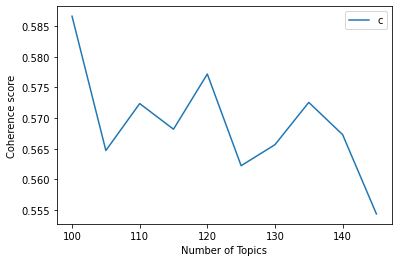

In [20]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
start=100 # start topic number
stop=150 # stop topic number
skip=5 # skip=5 , start,start+5,start+10.....stop
models2, values2= plot_graph(all_text,start,stop,skip,MALLET_PATH)

choose best topic number ⬇⬇⬇

In [22]:
topic_number=110
Tnumber=(topic_number-start)//5
values2[Tnumber] # coherence score

0.572369993094807

category label loading ⬇⬇⬇

In [23]:
with open('japanese_wiki_category.txt') as outfile:
     Tcat=json.load(outfile) 

In [24]:
topics=[]
for i in range(topic_number):
    topics.append([])

documents -- topic modeling ⬇⬇⬇

In [25]:
dictionary,bow_corpus=prepare_corpus(all_text)
topic_predictions = models2[Tnumber][bow_corpus]
best_topics = [[(topic, round(wt, 3))
                        for topic, wt in sorted(topic_predictions[i],
                                                key=lambda row: -row[1]) [:10]]
                            for i in range(len(topic_predictions))]
cnt=0
k=1
for doc in best_topics:
    cnt+=1
    for top in doc:
        topics[top[0]].append([top[1],top[0],cnt])
#         print("Score: {}\t Topic: {}".format(top[1], models2[Tnumber].print_topic(top[0], 10)))

In [26]:
for i in range(topic_number):
    topics[i].sort()

labeling topics ⬇⬇⬇

In [27]:
Tcat2=[]
for i in range(topic_number):
    Tcat2.append(Tcat['data'][topics[i][-1][2]-1]) 

In [37]:
topics2 = [[(term, round(wt, 3))
               for term, wt in models2[Tnumber].show_topic(n, topn=30)]
                   for n in range(0, topic_number)]
for idx, topic in enumerate(topics2):
    print('Topic #'+str(idx)+': '+Tcat2[idx])
    print([term for term, wt in topic])
    print()

Topic #0: Lifestyles
['社会', '科学', '生活', '研究', '理論', '主義', '様式', '意味', '行動', '言葉', '分析', '活動', '要素', '価値', '影響', '知識', '自己', '側面', '個人', '概念', '実践', '理解', '意識', '構造', '特徴', '用語', '手法', '排除', '自然', 'アメリカ']

Topic #1: Entertainment
['楽器', '管弦', 'オーケストラ', '表記', '編成', '和音', '音名', 'バス', '交響', '音域', 'オクターヴ', '音色', '長調', '奏法', '短調', '階名', '低音', 'ピアノ', '声域', 'ホルン', '使用', '唱法', 'イタリア', 'ドラム', '奏者', 'トランペット', '変化', '拡張', 'コード', '技法']

Topic #2: Beauty
['医薬', '医療', '製造', '販売', '薬剤', '使用', '安全', '効果', '管理', '機器', '薬局', '広告', '基準', '処方', '効能', '作用', '健康', '化粧', '部外', '許可', '表現', '目的', '表示', '必要', '分業', '承認', '食品', '厚生', '成分', '調剤']

Topic #3: Parenting and family
['検査', '染色', '質権', '結果', 'mtdna', '提供', '脚注', '系統', 'families', 'dna', '計量', '推定', 'american', '特定', 'ancestry', 'information', 'ハプログループ', 'testing', '継承', '比較', '塩基', 'マーカー', '個人', 'research', '会社', '共通', '一致', 'genealogical', '無題', 'genealogy']

Topic #4: Business
['名誉', '顧問', '日本', '会長', '新聞', '企業', '協会', '団体', 'バッジ', 'リーグ', '社長', '頭取', 

# Newtopic file

In [33]:
Newtopic={}
Newtopic['topics']=[]
for i,temp in enumerate(Tcat2):
    topic1={}
    topic1['category']=temp
    topic1['words']=topics2[i]
    Newtopic['topics'].append(topic1)

In [35]:
Newtopic['topics'][100:]

[{'category': 'Beauty',
  'words': [('コラーゲン', 0.028),
   ('細胞', 0.018),
   ('研究', 0.017),
   ('脂肪', 0.017),
   ('効果', 0.015),
   ('食品', 0.012),
   ('摂取', 0.011),
   ('アミノ', 0.011),
   ('作用', 0.01),
   ('報告', 0.01),
   ('ビタミン', 0.01),
   ('活性', 0.009),
   ('成分', 0.008),
   ('タンパク', 0.008),
   ('吸収', 0.008),
   ('反応', 0.007),
   ('実験', 0.007),
   ('分子', 0.007),
   ('体内', 0.007),
   ('酵素', 0.007),
   ('動物', 0.006),
   ('構造', 0.006),
   ('生物', 0.006),
   ('線維', 0.006),
   ('電子', 0.006),
   ('比較', 0.006),
   ('増加', 0.006),
   ('ヒト', 0.006),
   ('遺伝', 0.006),
   ('うがい', 0.006)]},
 {'category': 'Fitness and health',
  'words': [('酸素', 0.068),
   ('状態', 0.021),
   ('栄養', 0.017),
   ('障害', 0.017),
   ('呼吸', 0.013),
   ('濃度', 0.012),
   ('運動', 0.011),
   ('死亡', 0.011),
   ('必要', 0.011),
   ('神経', 0.011),
   ('維持', 0.01),
   ('摂取', 0.01),
   ('回復', 0.01),
   ('血流', 0.009),
   ('発生', 0.009),
   ('不足', 0.009),
   ('骨折', 0.008),
   ('運搬', 0.008),
   ('意識', 0.007),
   ('時間', 0.007),
   ('利用', 0.007),

In [36]:
with open('Newtopic.txt', 'w') as outfile:
    json.dump(Newtopic, outfile)

# Tdictionary file

In [40]:
# Topic dictionary
Tdictionary={}
cnt=0
for topic in Newtopic['topics']:
    for Word in topic['words']:
        temp={}
        temp['index']=cnt
        temp['score']=Word[1]
        if Tdictionary.get(Word[0]):
            Tdictionary[Word[0]].append(temp)
        else:
            Tdictionary[Word[0]]=[]
            Tdictionary[Word[0]].append(temp)
    cnt+=1

In [41]:
Tdictionary

{'社会': [{'index': 0, 'score': 0.06},
  {'index': 9, 'score': 0.016},
  {'index': 33, 'score': 0.01},
  {'index': 70, 'score': 0.015},
  {'index': 84, 'score': 0.006},
  {'index': 95, 'score': 0.017},
  {'index': 108, 'score': 0.018}],
 '科学': [{'index': 0, 'score': 0.037},
  {'index': 5, 'score': 0.006},
  {'index': 33, 'score': 0.019},
  {'index': 40, 'score': 0.006},
  {'index': 65, 'score': 0.022}],
 '生活': [{'index': 0, 'score': 0.022},
  {'index': 9, 'score': 0.014},
  {'index': 24, 'score': 0.007}],
 '研究': [{'index': 0, 'score': 0.019},
  {'index': 25, 'score': 0.011},
  {'index': 30, 'score': 0.005},
  {'index': 33, 'score': 0.006},
  {'index': 40, 'score': 0.048},
  {'index': 68, 'score': 0.012},
  {'index': 72, 'score': 0.026},
  {'index': 80, 'score': 0.019},
  {'index': 84, 'score': 0.004},
  {'index': 91, 'score': 0.008},
  {'index': 100, 'score': 0.017},
  {'index': 103, 'score': 0.006}],
 '理論': [{'index': 0, 'score': 0.018}, {'index': 91, 'score': 0.011}],
 '主義': [{'index':

In [42]:
with open('Tdictionary.txt', 'w') as outfile:
    json.dump(Tdictionary, outfile)